In [1]:
import os

from autocvd import autocvd
autocvd(num_gpus = 1)

import jax 
import jax.numpy as jnp
from jax import jit, random

import matplotlib.pyplot as plt


import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL, DIFFRAX_BACKEND, TSIT5, RK4
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity, sample_position_on_circle, inclined_position
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW

from odisseo.utils import halo_to_gd1_all, gd1_projection_vmap


plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})



In [ ]:
code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
# G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  


config = SimulationConfig(N_particles = 1_000, 
                          return_snapshots = True, 
                          num_snapshots = 500, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (4 * u.pc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.05 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)


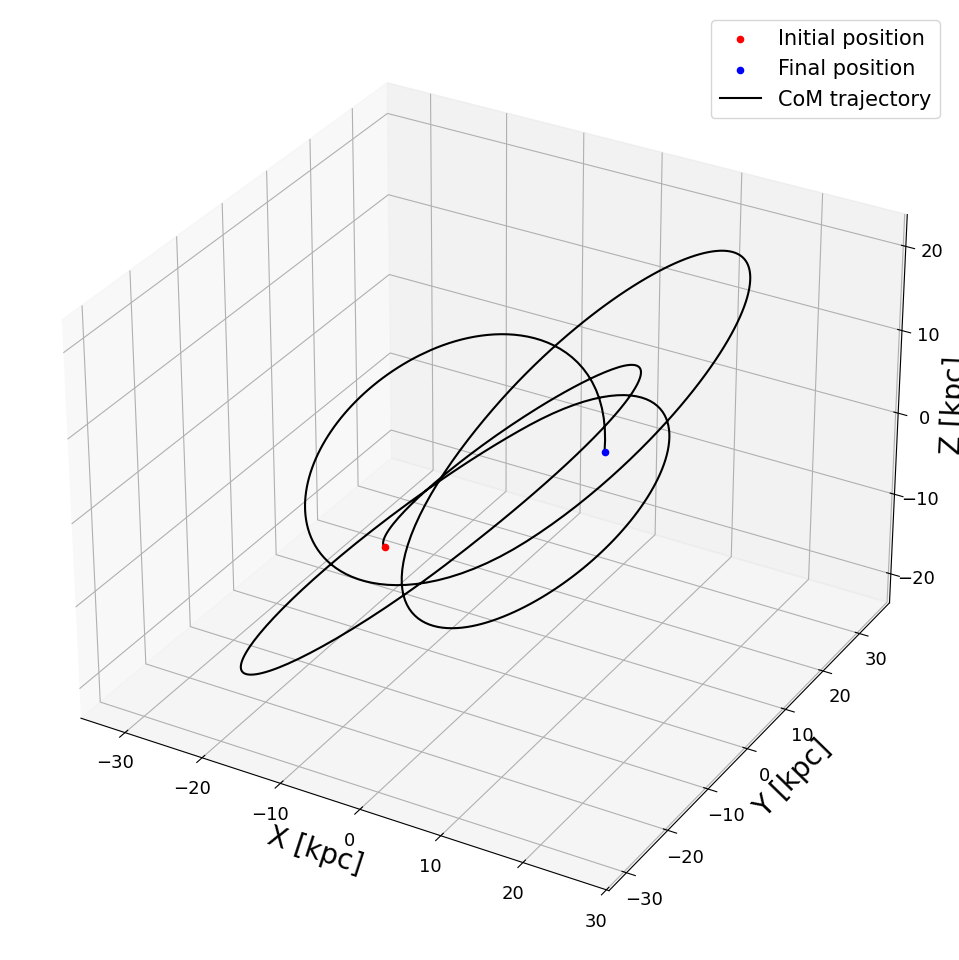

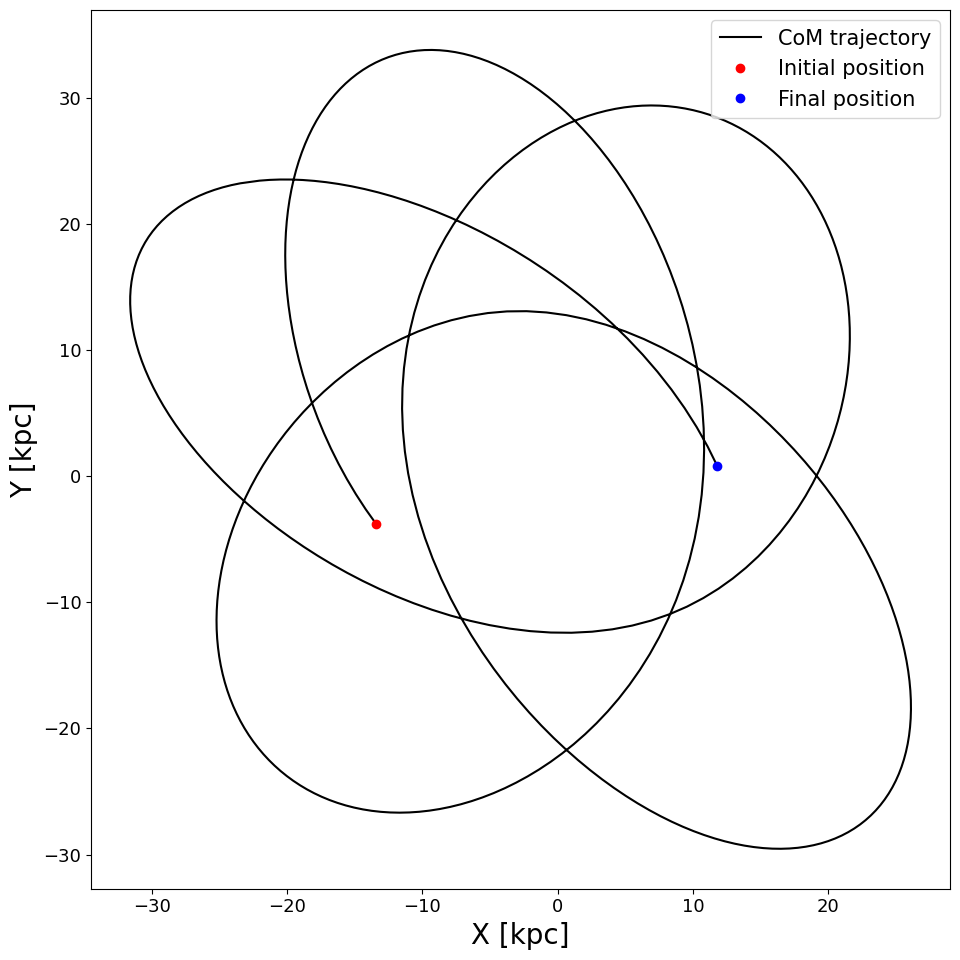

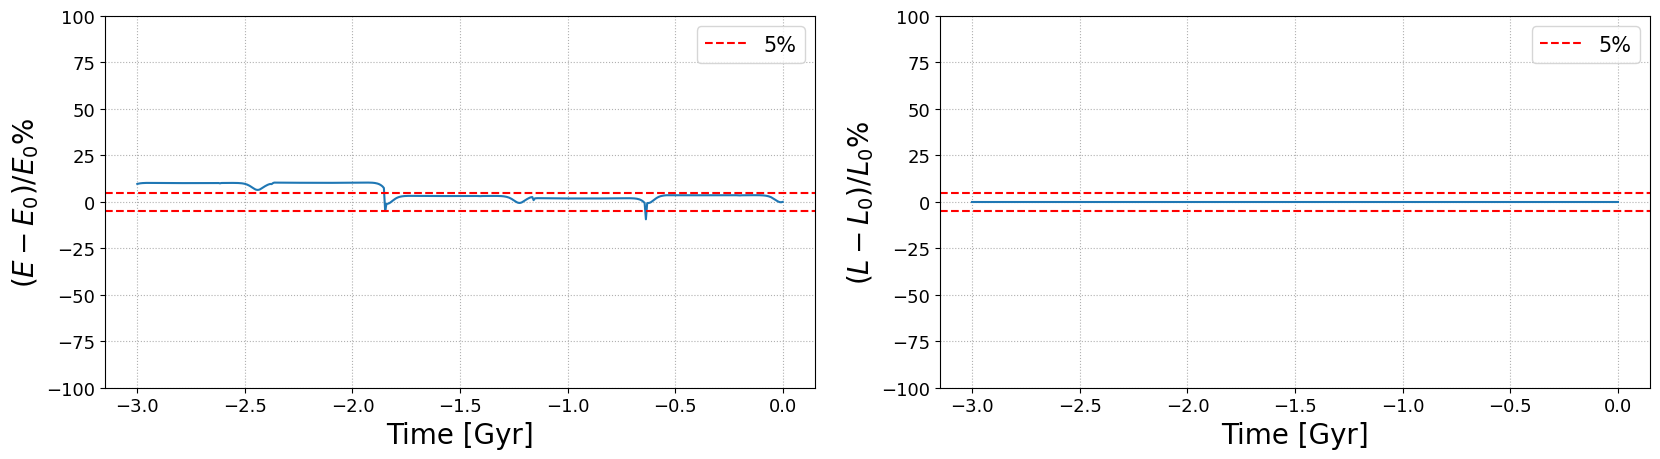

In [3]:
#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
params_com = params._replace(t_end=-params.t_end,)

#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
# pos_com_final = jnp.array([[12.4, 1.5, 7.1]]) * u.kpc.to(code_units.code_length)
# vel_com_final = jnp.array([[107.0, -243.0, -105.0]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]

##### CoM orbit plot####
fig = plt.figure(figsize=(15, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[-1,0, 0, 2]* code_units.code_length.to(u.kpc),c='r', label='Initial position')
ax.scatter(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[0,0, 0, 2]* code_units.code_length.to(u.kpc), c='b', label='Final position')
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:,0, 0, 2]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.set_zlabel("Z [kpc]")
ax.legend()
plt.show()

fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 'bo', label='Final position')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.legend()

energy_angular_momentum_plot(snapshots_com, code_units,)

# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

In [4]:
#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

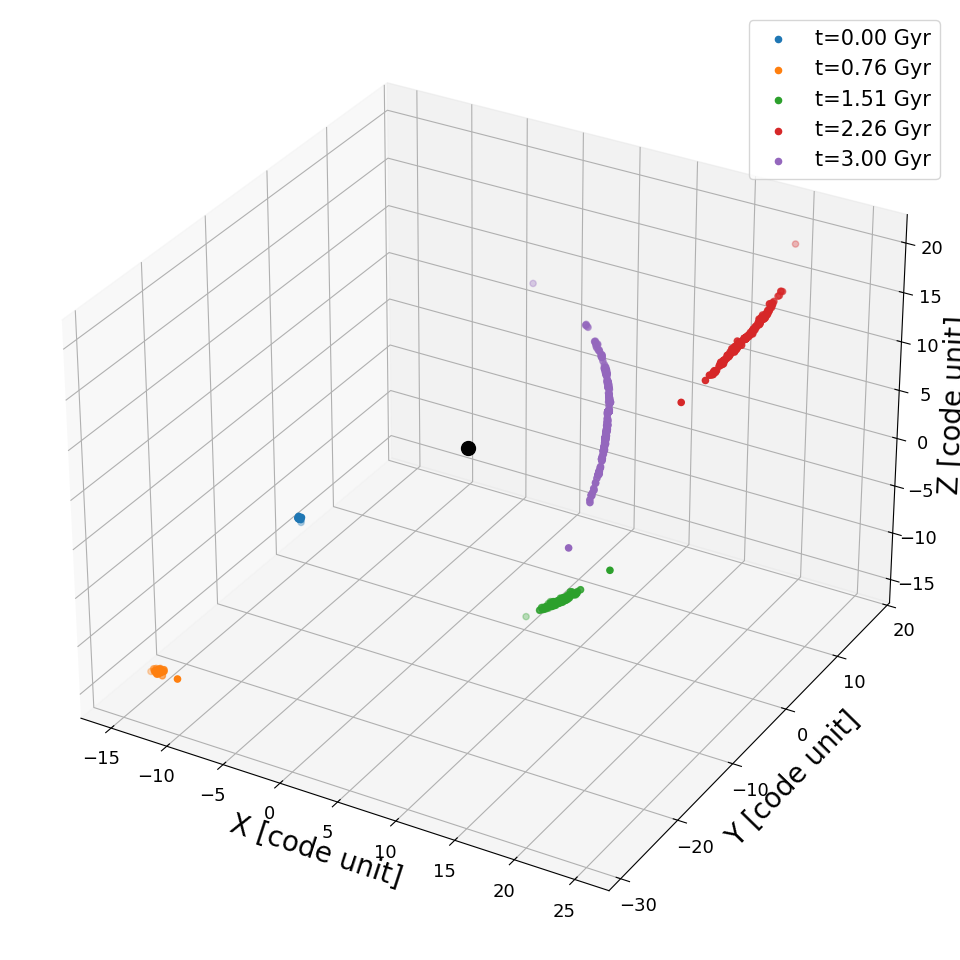

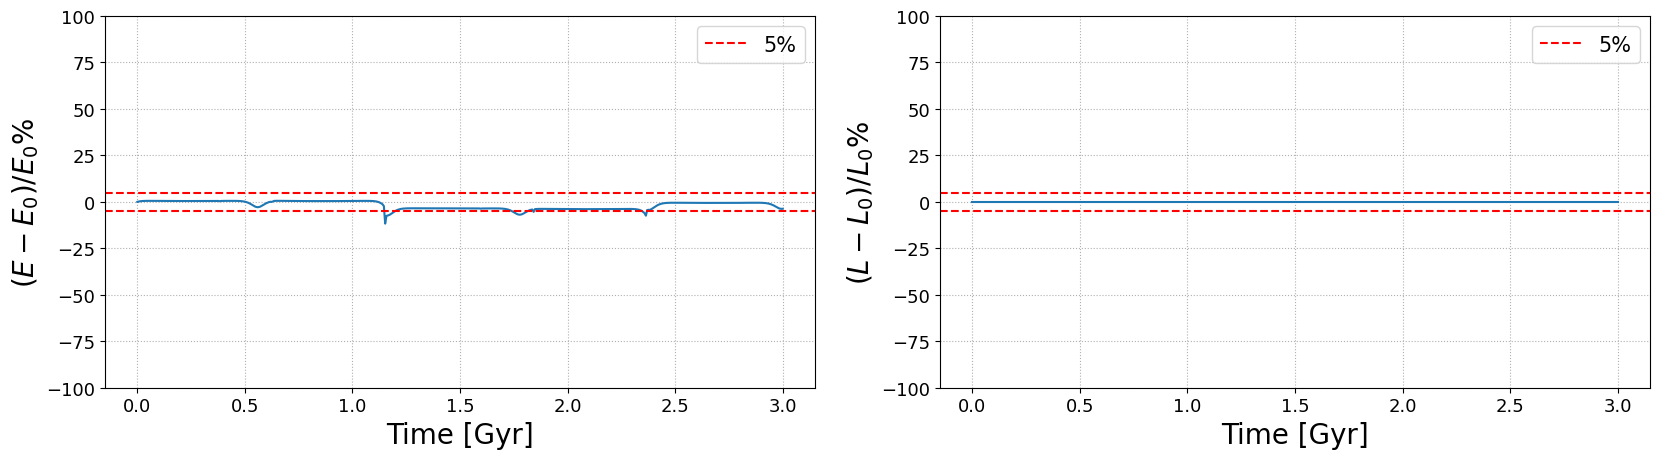

In [5]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
for i in np.linspace(0, config.num_snapshots, 5, dtype=int):
    ax.scatter(snapshots.states[i, :, 0, 0] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 1] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 2] * code_units.code_length.to(u.kpc), label=f"t={(snapshots.times[i]*code_units.code_time).to(u.Gyr):.2f}")
ax.scatter(0, 0, 0, c='k', s=100, )
ax.set_xlabel('X [code unit]')
ax.set_ylabel('Y [code unit]')
ax.set_zlabel('Z [code unit]')
# ax.set_xlim(-30, 30)
# ax.set_ylim(-30, 30)
# ax.set_zlim(-30, 30)
ax.legend()


energy_angular_momentum_plot(snapshots, code_units,)


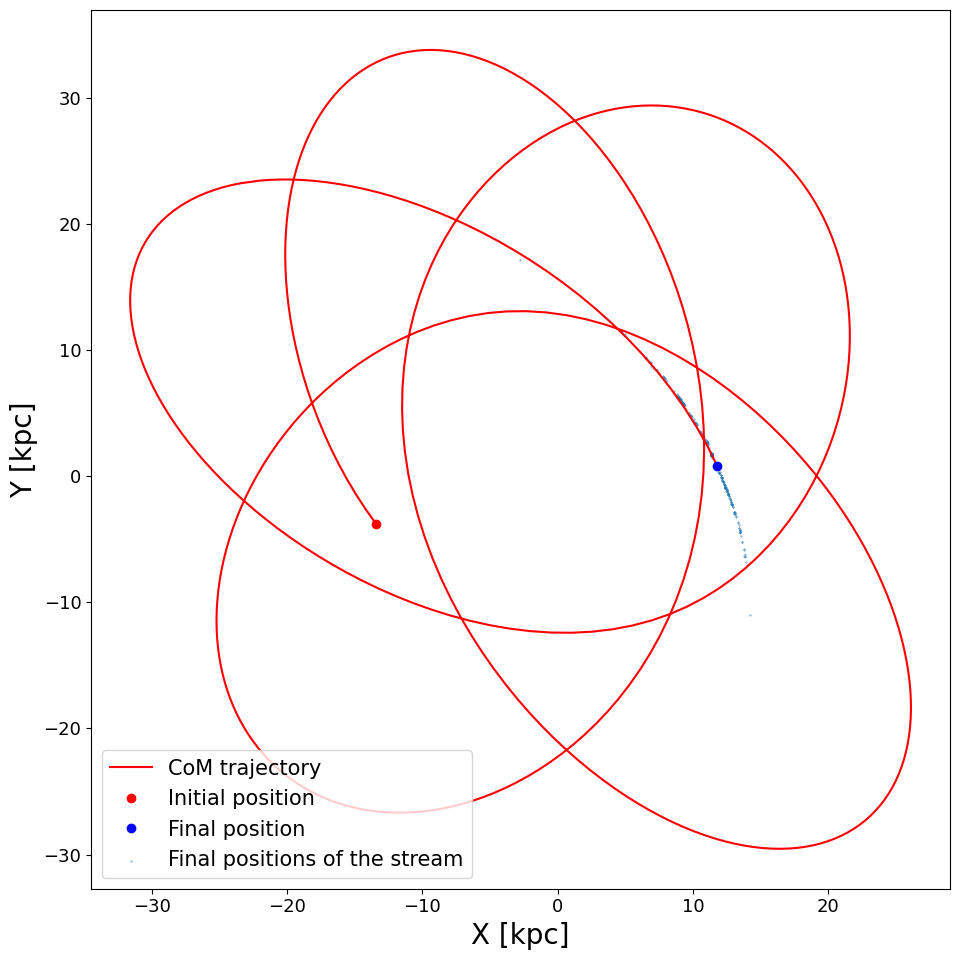

In [6]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 'r-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 'bo', label='Final position')
ax.scatter(snapshots.states[-1, :, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots.states[-1, :, 0, 1]* code_units.code_length.to(u.kpc), s=0.1, label='Final positions of the stream')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
# ax.set_xlim(-30, 30)
# ax.set_ylim(-30, 30)
ax.legend()

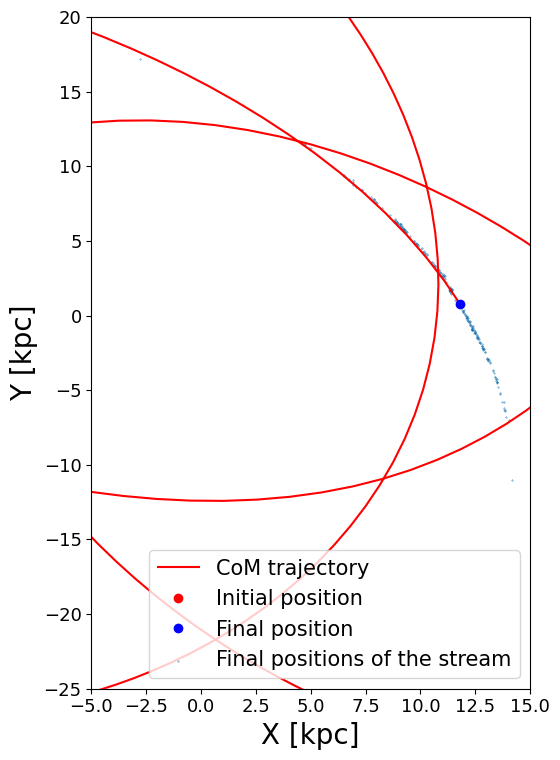

In [7]:
fig = plt.figure(figsize=(6, 8), tight_layout=True)
ax = fig.add_subplot(111)
conversion = code_units.code_length.to(u.kpc)
ax.plot(snapshots_com.states[:, 0, 0, 0]*conversion, 
        snapshots_com.states[:, 0, 0, 1]* conversion, 'r-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0]*conversion,
         snapshots_com.states[-1, 0, 0, 1]*conversion, 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0]*conversion, 
        snapshots_com.states[0, 0, 0, 1]*conversion, 'bo', label='Final position')
ax.scatter(snapshots.states[-1, :, 0, 0]*conversion, 
           snapshots.states[-1, :, 0, 1]*conversion, s=0.1, label='Final positions of the stream')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.set_xlim(-5, 15)
ax.set_ylim(-25, 20)
ax.legend()

In [8]:
import jax
import jax.numpy as jnp


@jax.jit
def halo_to_sun(Xhalo: jnp.ndarray) -> jnp.ndarray:
    """
    Conversion from simulation frame to cartesian frame centred at Sun
    Args:
      Xhalo: 3d position (x [kpc], y [kpc], z [kpc]) in simulation frame
    Returns:
      3d position (x_s [kpc], y_s [kpc], z_s [kpc]) in Sun frame
    Examples
    --------
    >>> halo_to_sun(jnp.array([1.0, 2.0, 3.0]))
    """
    sunx = 8.0   # Distance from the Sun to the Galactic Centre in kpc
    xsun = sunx - Xhalo[0]
    ysun = Xhalo[1]
    zsun = Xhalo[2]
    return jnp.array([xsun, ysun, zsun])


@jax.jit
def sun_to_gal(Xsun: jnp.ndarray) -> jnp.ndarray:
    """
    Conversion from sun cartesian frame to galactic co-ordinates
    Args:
      Xsun: 3d position (x_s [kpc], y_s [kpc], z_s [kpc]) in Sun frame
    Returns:
      3d position (r [kpc], b [rad], l [rad]) in galactic frame
    Examples
    --------
    >>> sun_to_gal(jnp.array([1.0, 2.0, 3.0]))
    """
    r = jnp.linalg.norm(Xsun)
    b = jnp.arcsin(Xsun[2] / r)
    l = jnp.arctan2(Xsun[1], Xsun[0])
    return jnp.array([r, b, l])


@jax.jit
def gal_to_equat(Xgal: jnp.ndarray) -> jnp.ndarray:
    """
    Conversion from galactic co-ordinates to equatorial co-ordinates
    Args:
      Xgal: 3d position (r [kpc], b [rad], l [rad]) in galactic frame
    Returns:
      3d position (r [kpc], alpha [rad], delta [rad]) in equatorial frame
    Examples
    --------
    >>> gal_to_equat(jnp.array([1.0, 2.0, 3.0]))
    """
    dNGPdeg = 27.12825118085622
    lNGPdeg = 122.9319185680026
    aNGPdeg = 192.85948
    dNGP = dNGPdeg * jnp.pi / 180.0
    lNGP = lNGPdeg * jnp.pi / 180.0
    aNGP = aNGPdeg * jnp.pi / 180.0
    r = Xgal[0]
    b = Xgal[1]
    l = Xgal[2]
    sb = jnp.sin(b)
    cb = jnp.cos(b)
    sl = jnp.sin(lNGP - l)
    cl = jnp.cos(lNGP - l)
    cs = cb * sl
    cc = jnp.cos(dNGP) * sb - jnp.sin(dNGP) * cb * cl
    alpha = jnp.arctan(cs / cc) + aNGP
    delta = jnp.arcsin(jnp.sin(dNGP) * sb + jnp.cos(dNGP) * cb * cl)
    return jnp.array([r, alpha, delta])


@jax.jit
def equat_to_gd1cart(Xequat: jnp.ndarray) -> jnp.ndarray:
    """
    Conversion from equatorial co-ordinates to cartesian GD1 co-ordinates
    Args:
      Xequat: 3d position (r [kpc], alpha [rad], delta [rad]) in equatorial frame
    Returns:
      3d position (x_gd1 [kpc], y_gd1 [kpc], z_gd1 [kpc]) in cartesian GD1 frame
    Examples
    --------
    >>> equat_to_gd1cart(jnp.array([1.0, 2.0, 3.0]))
    """
    xgd1 = Xequat[0] * (
        -0.4776303088 * jnp.cos(Xequat[1]) * jnp.cos(Xequat[2])
        - 0.1738432154 * jnp.sin(Xequat[1]) * jnp.cos(Xequat[2])
        + 0.8611897727 * jnp.sin(Xequat[2])
    )
    ygd1 = Xequat[0] * (
        0.510844589 * jnp.cos(Xequat[1]) * jnp.cos(Xequat[2])
        - 0.8524449229 * jnp.sin(Xequat[1]) * jnp.cos(Xequat[2])
        + 0.111245042 * jnp.sin(Xequat[2])
    )
    zgd1 = Xequat[0] * (
        0.7147776536 * jnp.cos(Xequat[1]) * jnp.cos(Xequat[2])
        + 0.4930681392 * jnp.sin(Xequat[1]) * jnp.cos(Xequat[2])
        + 0.4959603976 * jnp.sin(Xequat[2])
    )
    return jnp.array([xgd1, ygd1, zgd1])


@jax.jit
def gd1cart_to_gd1(Xgd1cart: jnp.ndarray) -> jnp.ndarray:
    """
    Conversion from cartesian GD1 co-ordinates to angular GD1 co-ordinates
    Args:
      Xgd1cart: 3d position (x_gd1 [kpc], y_gd1 [kpc], z_gd1 [kpc]) in cartesian GD1 frame
    Returns:
      3d position (r [kpc], phi1 [rad], phi2 [rad]) in angular GD1 frame
    Examples
    --------
    >>> gd1cart_to_gd1(jnp.array([1.0, 2.0, 3.0]))
    """
    r = jnp.linalg.norm(Xgd1cart)
    phi1 = jnp.arctan2(Xgd1cart[1], Xgd1cart[0])
    phi2 = jnp.arcsin(Xgd1cart[2] / r)
    return jnp.array([r, phi1, phi2])


@jax.jit
def halo_to_gd1(Xhalo: jnp.ndarray) -> jnp.ndarray:
    """
    Composed conversion from simulation frame co-ordinates to angular GD1 co-ordinates
    Args:
      Xhalo: 3d position (x [kpc], y [kpc], z [kpc]) in simulation frame
    Returns:
      3d position (r [kpc], phi1 [rad], phi2 [rad]) in angular GD1 frame
    Examples
    --------
    >>> halo_to_gd1(jnp.array([1.0, 2.0, 3.0]))
    """
    Xsun = halo_to_sun(Xhalo)
    Xgal = sun_to_gal(Xsun)
    Xequat = gal_to_equat(Xgal)
    Xgd1cart = equat_to_gd1cart(Xequat)
    Xgd1 = gd1cart_to_gd1(Xgd1cart)
    return Xgd1


jacobian_halo_to_gd1 = jax.jit(
    jax.jacfwd(halo_to_gd1)
)  # Jacobian for computing the velocity transformation from simulation frame to angular GD1 co-ordinates

halo_to_gd1_vmap = jax.jit(
    jax.vmap(halo_to_gd1, (0,))
)  # Vectorised version of co-ordinate transformation from simulation frame to angular GD1 co-ordinates


@jax.jit
def equat_to_gd1(Xequat: jnp.ndarray) -> jnp.ndarray:
    """
    Composed conversion from equatorial frame co-ordinates to angular GD1 co-ordinates
    Args:
      Xhalo: 3d position (x [kpc], y [kpc], z [kpc]) in simulation frame
    Returns:
      3d position (r [kpc], phi1 [rad], phi2 [rad]) in angular GD1 frame
    Examples
    --------
    >>> equat_to_gd1(jnp.array([1.0, 2.0, 3.0]))
    """
    Xgd1cart = equat_to_gd1cart(Xequat)
    Xgd1 = gd1cart_to_gd1(Xgd1cart)
    return Xgd1


jacobian_equat_to_gd1 = jax.jit(
    jax.jacfwd(equat_to_gd1)
)  # Jacobian for computing the velocity transformation from equatorial frame to angular GD1 co-ordinates


@jax.jit
def equat_to_gd1_velocity(Xequat: jnp.ndarray, Vequat: jnp.ndarray) -> jnp.ndarray:
    """
    Velocity conversion from equatorial frame co-ordinates to angular GD1 co-ordinates
    Args:
      Xequat: 3d position (r [kpc], alpha [rad], delta [rad]) in equatorial frame
      Vequat: 3d velocity (v_r [kpc/Myr], v_alpha [rad/Myr], v_delta [rad/Myr]) in equatorial frame
    Returns:
      3d velocity (v_r [kpc/Myr], v_phi1 [rad/Myr], v_phi2 [rad/Myr]) in angular GD1 frame
    Examples
    --------
    >>> equat_to_gd1_velocity(jnp.array([1.0, 2.0, 3.0]), jnp.array([1.0, 2.0, 3.0]))
    """
    return jnp.matmul(jacobian_equat_to_gd1(Xequat), Vequat)


@jax.jit
def halo_to_gd1_velocity(Xhalo: jnp.ndarray, Vhalo: jnp.ndarray) -> jnp.ndarray:
    """
    Velocity conversion from equatorial frame co-ordinates to angular GD1 co-ordinates
    Args:
      Xhalo: 3d position (x [kpc], y [kpc], z [kpc]) in simulation frame
      Vhalo: 3d velocity (v_x [kpc/Myr], v_y [kpc/Myr], v_z [kpc/Myr]) in simulation frame
    Returns:
      3d velocity (v_r [kpc/Myr], v_phi1 [rad/Myr], v_phi2 [rad/Myr]) in angular GD1 frame
    Examples
    --------
    >>> halo_to_gd1_velocity(jnp.array([1.0, 2.0, 3.0]), jnp.array([1.0, 2.0, 3.0]))
    """
    return jnp.matmul(jacobian_halo_to_gd1(Xhalo), Vhalo)
    


halo_to_gd1_velocity_vmap = jax.jit(
    jax.vmap(halo_to_gd1_velocity, (0, 0))
)  # Vectorised version of velocity co-ordinate transformation from simulation frame to angular GD1 co-ordinates


@jax.jit
def halo_to_gd1_all(Xhalo: jnp.ndarray, Vhalo: jnp.ndarray) -> jnp.ndarray:
    """
    Position and Velocity conversion from equatorial frame co-ordinates to angular GD1 co-ordinates
    Args:
      Xhalo: 3d position (x [kpc], y [kpc], z [kpc]) in simulation frame
      Vhalo: 3d velocity (v_x [kpc/Myr], v_y [kpc/Myr], v_z [kpc/Myr]) in simulation frame
    Returns:
      6d phase space (x [kpc], y [kpc], z[kpv], v_r [kpc/Myr], v_phi1 [rad/Myr], v_phi2 [rad/Myr]) in angular GD1 frame
    Examples
    --------
    >>> halo_to_gd1_all(jnp.array([1.0, 2.0, 3.0]), jnp.array([1.0, 2.0, 3.0]))
    """
    return jnp.concatenate((halo_to_gd1(Xhalo), halo_to_gd1_velocity(Xhalo, Vhalo)))


gd1_projection_vmap = jax.jit(
    jax.vmap(halo_to_gd1_all, (0, 0))
)  # Vectorised version of position and velocity co-ordinate transformation from simulation frame to angular GD1 co-ordinates

In [9]:
final_state = snapshots.states[-1].copy()
final_positions, final_velocities = final_state[:, 0], final_state[:, 1]

final_positions = final_positions * code_units.code_length.to(u.kpc)
final_velocities = final_velocities * code_units.code_velocity.to(u.kpc / u.Myr)

# Convert the final positions and velocities to GD1 coordinates
gd1_coordinate_pos = halo_to_gd1_vmap(final_positions)
gd1_coordinate_vel = halo_to_gd1_velocity_vmap(final_positions, final_velocities)

(-250.0, 250.0)

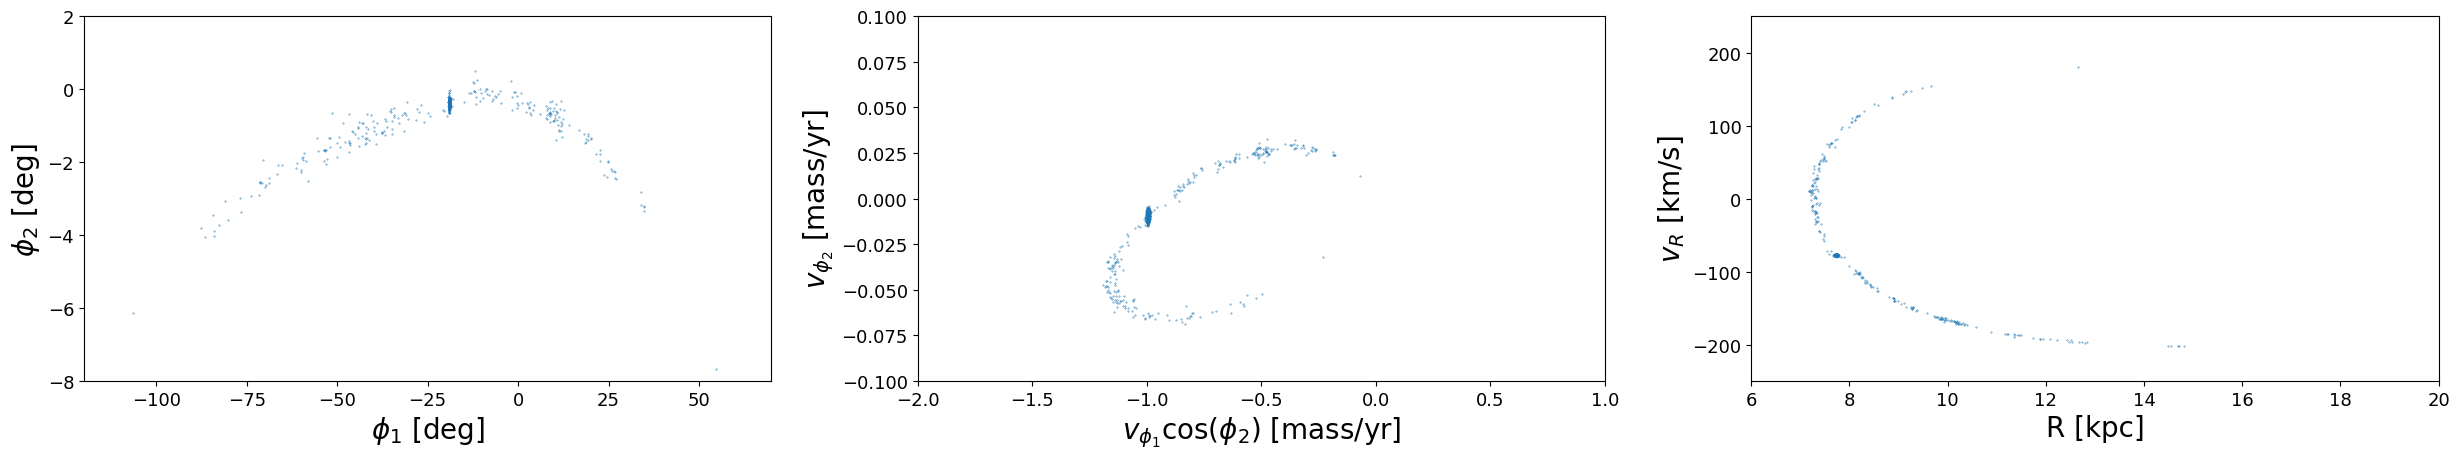

In [10]:

#this transformation works !
Xhalo = final_positions
Vhalo = final_velocities
Xgd1 = halo_to_gd1_vmap(Xhalo)
Vgd1 = halo_to_gd1_velocity_vmap(Xhalo, Vhalo)
Xgd1 = np.array(Xgd1)
Vgd1 = np.array(Vgd1)
Vgd1[:, 0] = Vgd1[:, 0] * (u.kpc/u.Myr).to(u.km/u.s)  # convert from kpc/Myr to km/s 
Vgd1[:, 1] = (
    Vgd1[:, 1] / Xgd1[:, 0] * 2.0626480624709636e8 / 1e6
)  # pm_phi1_cosphi2: converted from rad/Myr to mas/yr
Vgd1[:, 2] = (
    Vgd1[:, 2] / Xgd1[:, 0] * 2.0626480624709636e8 / 1e6
)  # pm_phi2: converted from rad/Myr to mas/yr
Xgd1[:, 1] = jnp.rad2deg(Xgd1[:, 1]) 
Xgd1[:, 2] = jnp.rad2deg(Xgd1[:, 2]) 

R = Xgd1[:, 0]  # kpc
phi1 = Xgd1[:, 1]  # deg
phi2 = Xgd1[:, 2]  # deg
vR = Vgd1[:, 0]  # km/s
v1 = Vgd1[:, 1]  # mass/yr
v2 = Vgd1[:, 2]  # mass/yr

fig = plt.figure(figsize=(25, 5), tight_layout=True)

ax = fig.add_subplot(131)
ax.scatter(phi1, phi2, s=0.1)
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)

ax = fig.add_subplot(132)
ax.scatter(v1 ,
           v2 ,
            s=0.1)
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mass/yr]")
ax.set_ylabel("$v_{\phi_2}$ [mass/yr]")
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)

ax = fig.add_subplot(133)
ax.scatter(R, vR , s=0.1)
ax.set_xlabel("R [kpc]")
ax.set_ylabel("$v_R$ [km/s]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)


KeyboardInterrupt: 

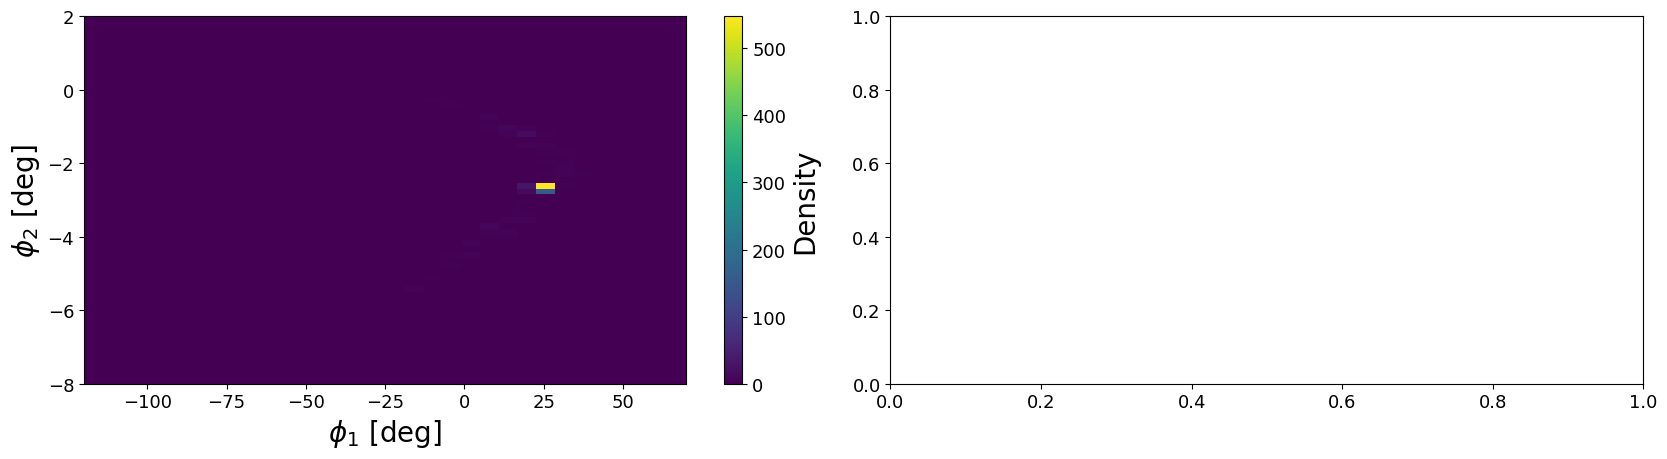

In [ ]:
fig = plt.figure(figsize=(25, 5), tight_layout=True)

# Define bin edges and create meshgrids
phi1_bins = jnp.linspace(-120, 70, 65)    # 64 bins
phi2_bins = jnp.linspace(-8, 2, 33)       # 32 bins
v1_bins = jnp.linspace(-2., 1.0, 65)      # 64 bins  
v2_bins = jnp.linspace(-0.10, 0.10, 33)   # 32 bins
R_bins = jnp.linspace(6, 20, 65)          # 64 bins
vR_bins = jnp.linspace(-250, 250, 33)     # 32 bins

# Create meshgrids for bin centers
phi1_centers = (phi1_bins[1:] + phi1_bins[:-1]) / 2
phi2_centers = (phi2_bins[1:] + phi2_bins[:-1]) / 2
PHI1, PHI2 = jnp.meshgrid(phi1_centers, phi2_centers, indexing='ij')

v1_centers = (v1_bins[1:] + v1_bins[:-1]) / 2
v2_centers = (v2_bins[1:] + v2_bins[:-1]) / 2
V1, V2 = jnp.meshgrid(v1_centers, v2_centers, indexing='ij')

R_centers = (R_bins[1:] + R_bins[:-1]) / 2
vR_centers = (vR_bins[1:] + vR_bins[:-1]) / 2
R_GRID, VR_GRID = jnp.meshgrid(R_centers, vR_centers, indexing='ij')

# Create 2D histograms
ax = fig.add_subplot(131)
counts1 = jnp.histogram2d(phi1, phi2, bins=[phi1_bins, phi2_bins], )[0]
im1 = ax.imshow(counts1, origin='lower', aspect='auto', cmap='viridis',
                extent=[phi1_bins[0], phi1_bins[-1], phi2_bins[0], phi2_bins[-1]])
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)
plt.colorbar(im1, ax=ax, label='Density')

ax = fig.add_subplot(132)
counts2 = jnp.histogram2d(v1, v2, bins=[v1_bins, v2_bins], density=True)[0]
im2 = ax.imshow(counts2.T, origin='lower', aspect='auto', cmap='viridis',
                extent=[v1_bins[0], v1_bins[-1], v2_bins[0], v2_bins[-1]])
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mas/yr]")
ax.set_ylabel("$v_{\phi_2}$ [mas/yr]")
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)
plt.colorbar(im2, ax=ax, label='Density')

ax = fig.add_subplot(133)
counts3 = jnp.histogram2d(R, vR, bins=[R_bins, vR_bins], density=True)[0]
im3 = ax.imshow(counts3.T, origin='lower', aspect='auto', cmap='Blues',
                extent=[R_bins[0], R_bins[-1], vR_bins[0], vR_bins[-1]])
ax.set_xlabel("R [kpc]")
ax.set_ylabel("$v_R$ [km/s]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)
plt.colorbar(im3, ax=ax, label='Density')